# Setting up environment

In [ ]:
# ONLY IF INSTALATION FAILED: Deleting any colorbot-workshop already existing
#!rm -rf /content/colorbot-workshop
#%cd /content

In [ ]:
# Clone the repository
!git clone https://github.com/Atuxen/colorbot-workshop.git

In [ ]:
%cd colorbot-workshop
!pip install .

### Now drag and drop the `mqtt_secrets.py`given from the instructors into the content/colorbot-workshop folder, found in the left panel in collab.
Once you have put the `mqtt_secrets.py` in the folder, you can go to Exercise 1 if in silicobot group or Excercise 2 if in colorbot group.


# Exercise 1 (SILICOBOT MEMBERS START HERE) 
## In silico color mixing and optimization
We start working with a digital version of the colorbot. Here you can experiment with your code prior to deploying it on the actual pumpbot. 

- The silicobot instance of `SilicoPumpController`, is initialized with the standard deviation of noise, `noise_std`. 
- For now, we initiate it without any noise to demonstrate its basic functionalities. 
- Notice that when you instantiate `silicobot_no_noise`, you will also generate a file with current timestamp under the *silicologs* folder in your current directory. 


In [ ]:
from pump_controller import * 
silicobot_no_noise = SilicoPumpController(noise_std=0)

### Let's first look at how to mix colors.


The `input_volumes` is a list of 4 values that correspond to red, green, blue, and yellow. In this case, we are just putting red color solution. You can "measure" its color using the following command. 

In [ ]:
input_volumes = [1.0, 0., 0., 0.]
measured_color = silicobot_no_noise.mix_color(input_volumes)
print(f"The RGB value of the color you mixed is {measured_color}.")

The `measured_color` shows the RGB value of your mixture. In this case, you have pure red since you only put an ideal red color. In reality this will not be the case since:
 1. There will be measurement errors from your color sensor
 2. Your color solution will not be pure RGB red. 

Now we'll account for both:

First, you can introduce noise in the measurement by setting `noise_std` value. 
We now initialize `silicobot` with a noise value of 5, and then make a couple of samples. 

In [ ]:
silicobot = SilicoPumpController(noise_std = 5)

mixed_colors = []
input_volumes=[1.0, 0.0, 0.0, 1.0]
for n in range (10):
    color = silicobot.mix_color(input_volumes)
    print(f'Mix {n} = {color}')
    mixed_colors.append(color)

plt.axis('off')
plt.imshow(np.array([mixed_colors], dtype=np.uint8))

### Second to the measurrement inprecisison, we can micmic an estimate of the true color solutions used 
By measring the RGB values of the solutions, and replacing the values of `r`, `g`, `b`, and `y` below with your measured values, we can remake the real colors.

In [ ]:
# GET THESE VALUES FROM YOUR GROUP MEMBERS, WHEN READY
r = [174, 42, 35]
g = [71, 121, 56]
b = [31, 103, 107]
y = [143, 70, 37]

silicobot.set_color_coefficient(r=r,g=g, b=b, y=y)

# Let's now simulate a meassurement of the red solution.
input_volumes = [1.0, 0., 0., 0.]
measured_color = silicobot.mix_color(input_volumes)
print(f"The color you mixed is {measured_color}.")

### Setting a target for the optimization
You will be given a target color that you are tasked to match by mixing red, green, blue, and yellow. 
You will not know the components of the target color that you want to match, but can only measure RGB color of the target mixture. 

In [ ]:
target =  [71, 121, 56]# GET THIS VALUES FROM YOUR GROUP MEMBERS, WHEN READY
silicobot.target_color = target
print(f"RGB of the target color is: {silicobot.target_color}")

### Now we will perform an *in siloco* mixture:

In [ ]:
input_volumes = [0.4, 0.3, 0.2, 0.1]
measured_color = silicobot.mix_color(input_volumes)
target = silicobot.target_color
visualize_rgb(mixture = input_volumes,
              rgb = measured_color,
              pump_controller = silicobot,
              target = target,
              score = None
              )

Legend:

* The outer-most ring shows the color mixture that you used to mix the color. 
* The large ring shows that color that you actually mixed
* The inner circle shows the target color. 
* The number in the middle is the objective function score (you don't have that yet). 

### Objective function score

The mixed color and the target color are very different - but how different are they?

To answer this, **you** will have to define a function that takes the color (r, g, b) and target (r, g, b) as inputs and returns some quantitative measure for the difference. There are many ways to define the difference between the two colors. If you need inspiration, you could make a function that returns the root summed squared error for each of the r, g, b channels, $\sqrt((\Delta r)^2+(\Delta g)^2+(\Delta b)^2)$. This function should take the inputs (r, g, b) tuples (or lists, arrays, etc.) as `input_color1` and `input_color2`, and output a score.



Now it's up to you to define a score function, based on the difference between the target and the measured RGB values.

In [ ]:
def color_difference(measured_color, target_color):
    # Your code goes here:

    # TODO: REMOVE
    error = np.array(measured_color) - np.array(target_color)
    rmse = np.sqrt(np.mean(error**2))
    score = rmse
    # TODO REMOVE

    return score

In [ ]:
input_volumes = [0.4, 0.3, 0.2, 0.1]
measured_color = silicobot.mix_color(input_volumes)
score = color_difference(measured_color, target)
visualize_rgb(mixture = input_volumes,
              rgb = measured_color,
              pump_controller = silicobot,
              target = target,
              score = score
              )

For the optimization, we would like to have am objective function that relates input parameters (R,G,B,Y), to a score based on the color difference from the target. You'll need to combine what you know about hte silicobot mixing and your new color difference function.


In [22]:
optimization_history = []

def find_score_from_color(input_volumes):
    """
    Objective function that mixes colors and calculates score.
    Handles both tensor and numpy array inputs properly.
    """
    # TODO: REMOVE
    mixture = silicobot.mix_color(input_volumes)  # Change to colorbot for real robot
    target = silicobot.target_color  # Or use your defined target
    score = color_difference(mixture, target)
    # TODO: REMOVE


    # For visualization
    global optimization_history
    optimization_history.append({
        'mixture': input_volumes.numpy().copy(),  # Use normalized values
        'measurement': np.array(mixture),
        'target_measurement': np.array(target),
        'score': float(score) 
    })
    # Clear previous output for clean display
    df = pd.DataFrame(optimization_history)
    display.clear_output(wait=True)
    visualize_candidates(df)

    return score


Before we move on, you are reminded that you can always find logs under silicologs, and that Help will always be given at Hogwarts to those who ask for it.

In [ ]:
from pump_controller import read_logfile, visualize_candidates
logs = read_logfile(silicobot.log_file)
logs

# Optimization

Now that you have defined your objective function, we can start defining the optimization problem.

In [ ]:
from IPython import display

# Odyssey 
from odyssey.mission import Mission # Mission
from odyssey.objective import Objective # Objective
from odyssey.navigators import SingleGP_Navigator, DataLoader # Navigator
from odyssey.navigators.sampler_navigators import Sobol_Navigator, Grid_Navigator # Sampler
from odyssey.navigators import ExpectedImprovement, ProbabilityOfImprovement, UpperConfidenceBound, LogExpectedImprovement, LogProbabilityOfImprovement # Acquisition functions

# Other Packages
import matplotlib.pyplot as plt
from IPython import display
from warnings import catch_warnings, simplefilter

The Objective class is a wrapper for enforcing tensor input/output. 

In [23]:
objective = Objective(func=find_score_from_color)

We define optimization problem using Odyssey's `Mission` class, which takes several attributes.  

```python
mission = Misson(name='Name of your experiment',
                 funcs=[],
                 maneuvers=goals,
                 envelope=param_space)
```

- The `funcs` is a list of objective functions
-  `manuevers` is a list of goals conrresponding to each objective function, which can be either ascend (i.e., finding global maximum) or descend (i.e., finding global minimum). 
-   `envelope`is the parameter space bounds. Each tuple is a parameter bound, corresponding to the parameter input

In [24]:
mission = Mission(name="Minimizing the color difference",
                  funcs=[objective],
                  maneuvers=['descend'],
                  envelope=[(0.0, 1.0),(0.0, 1.0),(0.0, 1.0),(0.0, 1.0)])

We have now defined our optimization problem. 
The next step is to specify how we would like to navigate through our search space, and we achieve this using `Navigator` class. 

We use `SingleGP_Navigator` for single-objective Bayesian optimization, which employs a single Gaussian Process (GP) model to approximate the objective function and guide the search for the optimal solution using an acquisition function. The first step of the optimization sequence to explore a fixed set of initial data points before using the acquisition function. Let's explore 3 initial points, which is selected in a uniform fashion by dividing our search space into grids. Once the initial points are explored, we will continue the optimization by using `ExpectedImprovement` as an acquisition function. 

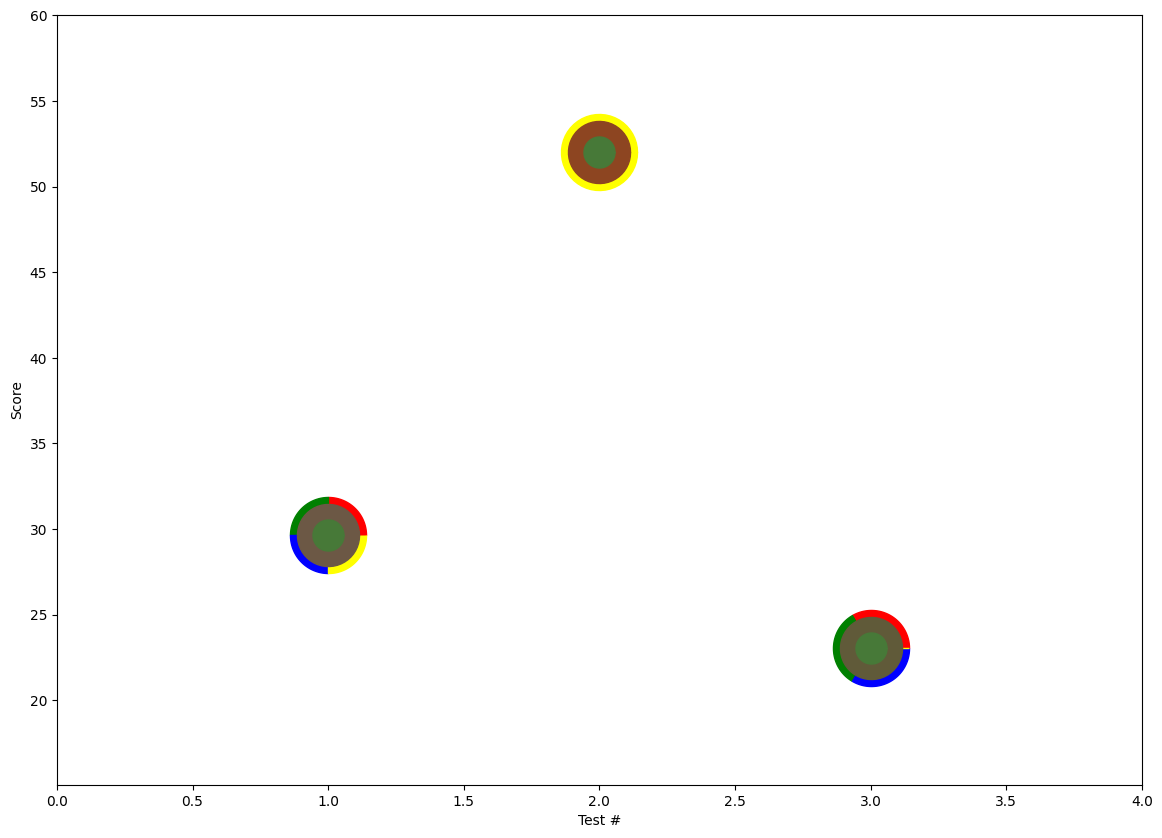

Succesfully appended {'param_1': [1.0, 0.0, 0.5], 'param_2': [1.0, 0.0, 0.5], 'param_3': [1.0, 0.0, 0.5], 'param_4': [1.0, 0.5, 0.0], 'objective_1': [29.626566505305593, 52.032845015650594, 23.073976324324054], 'creation_timestamp': '25-08-25 17:36:14'} to missionlogs/Minimizing the color difference-250825_173612.csv


In [25]:
num_init_points = 3
navigator = SingleGP_Navigator(mission=mission,
                               num_init_design=num_init_points,
                               input_scaling=True,
                               data_standardization=False,
                               init_method=Grid_Navigator(mission=mission, subdivisions=num_init_points),
                               acq_function_type=ExpectedImprovement,
                               acq_function_params={'best_f': 0.0}
)

Initiating the navigator above has selected 3 points and evaluated the objective function. You can now run the optimizer. 

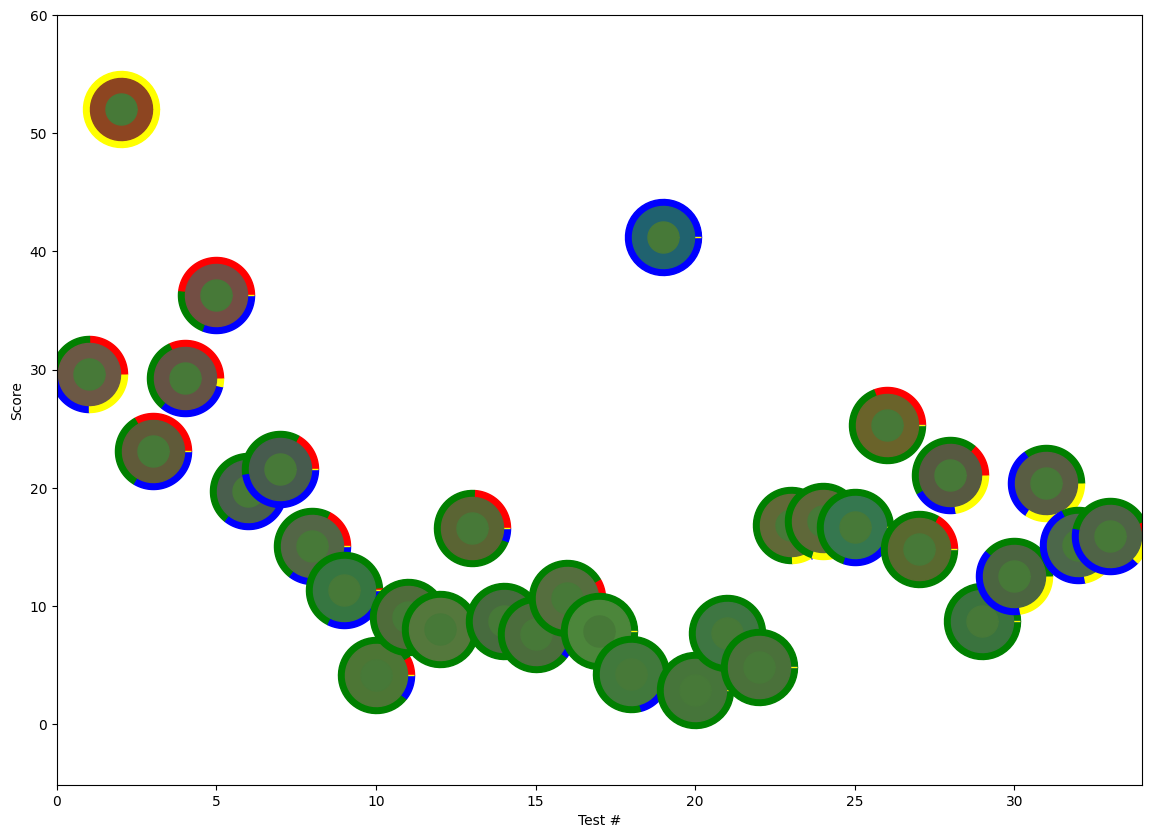

Succesfully appended {'param_1': [0.17026769632106192], 'param_2': [0.9843917892321578], 'param_3': [1.0], 'param_4': [0.29942813248692957], 'objective_1': [15.94370128866139], 'creation_timestamp': '25-08-25 17:36:32'} to missionlogs/Minimizing the color difference-250825_173612.csv


In [ ]:
num_iter = 50

from warnings import catch_warnings
from warnings import simplefilter

for i in range(num_iter):
    with catch_warnings() as w:
        simplefilter('ignore')
        trajectory = navigator.trajectory()
        observation = navigator.probe(trajectory, init = False)
        navigator.relay(trajectory, observation)
        navigator.upgrade()

In [ ]:
best_idx = mission.display_Y.argmin().item()
best_input = mission.display_X[best_idx,]
best_output = mission.display_Y[best_idx].item()

print(f'Best Input: {best_input}')
print(f'Best Output: {best_output}')

visualize_rgb(mixture = np.array(best_input),
              rgb = silicobot.mix_color(best_input),
              pump_controller = silicobot,
              target = target,
              score = best_output
              )

You are now ready to go to exercise 3 when you're group members are ready. If theyre not ready, have a peak at the exercise 2.

# Exercise 2 (COLORBOT MEMBERS START HERE) 
## Connecting to the Colorbot pump controller

In [ ]:
from pump_controller import PumpController, get_serial_port, list_serial_ports, visualize_rgb, visualize_candidates
print("Initialization finished!")

### Connect to your colorbot, by assigning your group number to the id
If the colorbot returns "Colorbot is ready", the machine is connected.

In [ ]:
# Put here the number of the colorbot you are using, to connect to right machine
group_no = 5 #1, 2, 3, 4, 5
colorbot = PumpController(id = group_no, 
                          ser_port = None, 
                          drain_time=6, 
                          cell_volume=45, 
                          config_file="./config_files/config.json")

### Communication with the machine is done via the MQTT broker HiveMQ
Each machine is listening to a topic, and each client is publishing tasks on that topic. Task requests are synchronised with a request id. You can request `hello_colorbot` below, and see that the microcontrolers onboard LED light up, and a response is displayed below.

In [ ]:
task = "hello_colorbot"
msg = colorbot.mqtt_task_manager(task)
print(msg)

### Fill colors solutions and water on the robot
Get colors from the teacher, and fill the bottles according to the labels

### Priming pumps
Before diving in running protocols on the machine, we start with the basic functionaility. Below you can run the pumps for a set amount of seconds. Later we will be able to dispense volume. REMEMBER TO DRAIN THE CELL FREQUENTLY!

In [ ]:
seconds_run = 2.0 # Do not put this higher than 5, as this will cause overflow in the cell.

### Pumping with the RGBY pumps
colorbot.purge_pump('R', seconds_run)
#colorbot.purge_pump('G', seconds_run)
#colorbot.purge_pump('B', seconds_run)
#colorbot.purge_pump('Y', seconds_run)
colorbot.drain() # REMEMBER TO DRAIN TO CELL!!

### Draining and cleaning the cell
In the colorbot universe, we use water to flush the test cell between measurements. You can run reset() to prepare the cell for a new measurement 

In [ ]:
### Water flush
colorbot.flush()

### Drain
colorbot.drain()

### RESET CELL: This commands first drain(), then flush() and then drain() again. This resets the cell for new measurement
#colorbot.reset()

### Measure color value of cell content (CELL NEEDS TO BE FILLED)
When you run this command, you the LEDs will light up the cell, and the color sensor will capture and average RGB value and return it over the broker. The color sensor needs a filled cell, and you can expect a grey color with values around(90,85,60) for an empty cell. 

In [ ]:
# Capture and display average RGB value
rgb = colorbot.measure()

### Measure color solutions
- For each color solution, fill the test cell and capture the RGB values.
- Write down the values, and pass them to you silicobot group members
- Get a target color solution from the teachers, and likewise measure the RGB values. 

In [ ]:
# GIVE THESE VALUES TO YOUR GROUP MEMBERS, WHEN READY
r = []
g = []
b = []
y = []

target = [0,0,0]

### Dispensing volume
The pumps used on the colorbot have been calibrated by fitting a regression line on values measured. The configuration can be found under config if you have interest. Since we have calibrated it prior to this exercise, we can dispense volumes.

The colorbot.mix_color method is a protocol which do:
- Mix the ratio of each color channel normalised to the cell volume. (e.g. if you want euqal amounts of each, run colorbot.mix_color([1,1,1,1]))
- Then measures the RGB 
- Finally resets the cell, by draining, flushing and draining

In [ ]:
# Try to perform a mix, and check the log files
colorbot.mix_color([1,1,1,1])

logs = read_logfile(colorbot.log_file)
logs

# Exercise 3: Bayesian optimization on colorbot

All group members now join forces to make the Colorbot run Bayesian optimization.

In [ ]:
from pump_controller import PumpController, get_serial_port, list_serial_ports, visualize_rgb, visualize_candidates
print("Initialization finished!")

In [ ]:
# Put here the number of the colorbot you are using, to connect to right machine
group_no = 5 #1, 2, 3, 4, 5
colorbot = PumpController(id = group_no, 
                          ser_port = None, 
                          drain_time=6, 
                          cell_volume=45, 
                          config_file="./config_files/config.json")

### Now we will run the Bayesian optimization of the colorbot. 
We will reuse the data from the Silico exercises in Excercise 1, but we will have to redefine the objective function to use the colorbot mixing. Use the computer which ran the exercise 1, as this will contain the prior data. Group members from Exercise 2, can help on how to run protocols on the colorbot.

In [ ]:
# function for getting the color difference
def color_difference(measured_color, target_color):
    # your code goes here

    # REMOVE
    error = np.array(measured_color) - np.array(target_color)
    rmse = np.sqrt(np.mean(error**2))
    score = rmse
    # REMOVE

    return score

Try mix a color on the colrobot, and check the score:

In [ ]:
input_volumes = [0.4, 0.3, 0.2, 0.1]
measured_color = colorbot.mix_color(input_volumes)
score = color_difference(measured_color, target)
visualize_rgb(mixture = input_volumes,
              rgb = measured_color,
              pump_controller = colorbot,
              target = target,
              score = score
              )

In [ ]:

# Global list to store optimization history
optimization_history = []

def find_score_from_color(input_volumes):
    """
    Objective function that mixes colors and calculates score.
    Handles both tensor and numpy array inputs properly.
    """

    # TODO: REMOVE
    mixture = colorbot.mix_color(input_volumes)  # Change to colorbot for real robot
    target = target  # Or use your defined target
    score = color_difference(mixture, target)
    # TODO: REMOVE


    # For visualization only
    global optimization_history
    optimization_history.append({
        'mixture': input_volumes.numpy().copy(),  # Use normalized values
        'measurement': np.array(mixture),
        'target_measurement': np.array(target),
        'score': float(score) 
    })
    # Clear previous output for clean display
    df = pd.DataFrame(optimization_history)
    display.clear_output(wait=True)
    visualize_candidates(df)

    return score

objective = Objective(func=find_score_from_color)
mission.funcs = [objective]

### We can now run the optimizer with the Silico prior data:

Run the optimizer

In [ ]:
num_iter = 10

for i in range(num_iter):
    with catch_warnings() as w:
        simplefilter('ignore')
        trajectory = navigator.trajectory()
        observation = navigator.probe(trajectory, init = False)
        navigator.relay(trajectory, observation)
        navigator.upgrade()      
     
     
best_idx = mission.display_Y.argmin().item()
best_input = mission.display_X[best_idx,]
best_output = mission.display_Y[best_idx].item()

print(f'Best Input: {best_input}')
print(f'Best Output: {best_output}')

visualize_rgb(mixture = np.array(best_input),
              rgb = silicobot.mix_color(best_input),
              pump_controller = silicobot,
              target = target,
              score = best_output
              )



# Exercises finished!